In [29]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import time # modeli yaddaşa verərkən lazımdır

In [30]:
# keras-ın Callback classını override edərək öz istədiyimiz funksionallığı burada qeyd edirik.
class Xetle(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print(str(epoch) + ', ', end='')


        
# Bu funksiya vasitəsilə məşğələ nəticəsinin qrafikini çəkirik
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Ortalamanın mütləq xətası [AZN]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Məşğələ Xətası')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Dəyər Xətası')
  plt.legend()
#   plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Otralamanın Kvadrat Xətası[AZN^2]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Məşğələ Xətası')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Dəyər Xətası')
  plt.legend()


In [31]:
# pandas seçimləri - bunlar olmadan pandas dataları haqqında məlumatı ekrana yazdıranda məlumatlar icmal formasında görünür.
# Bunları # işarəsi ilə comment edə bilərsiniz. Mən məlumatları tam görmək istədiyim üçün bunları saxlayıram.

# Maksimal sətirlərin sayı
pd.set_option('display.max_rows', 5000)
# Maksimal sütunların sayı
pd.set_option('display.max_columns', 5000)
# Enin uzunluğu
pd.set_option('display.width', 1000)

In [32]:
# Bizə lazım olan məlumat, bütün analiz buradakı məlumatlara əsasən aparılacaq
car_data = '07_FULL_LIST.csv'

In [33]:
# csv faylında sütun adları olmadığı üçün onları əlavə edirik. Adları özüm ingilis diliində təyin etmişəm. Siz stədiyinizi yazın
column_names = ['car_name', 'price', 'year', 'engine', 'mileage', 'valyuta']

# faylı parse edirik və məlumatları pandas dataframe formatına çeviririk.
raw_dataset = pd.read_csv(car_data, names=column_names, na_values = "?", comment='\t', sep=",", skipinitialspace=True,
                          encoding='ISO-8859-1')
dataset = raw_dataset.copy()

In [34]:
# .head datasetdə ilk sətirləri, .tail() isə datasetdə son sətirləri ekrana çıxarır.
dataset.head()

,car_name,price,year,engine,mileage,valyuta
0,LADA (VAZ) 2107,6900,2012,1.6,10900,AZN
1,LADA (VAZ) 2107,6100,2010,1.6,151365,AZN
2,LADA (VAZ) 2107,6600,2010,1.6,150000,AZN
3,LADA (VAZ) 2107,3100,2000,1.6,165000,AZN
4,LADA (VAZ) 2107,3900,2003,1.6,250000,AZN


In [35]:
# Maşın adı və valyuta sütunlarını siyahıdan çıxarırıq. 
# Çünki, onlar bütü sətirlərdə eynidir. İstəsəniz motor ölçüsünü də çıxara bilərsiniz.
dataset.pop('car_name')
dataset.pop('valyuta')
# Sütunları çıxdıqdan sonra məlumata baxaq və əmin olaq ki, sütunlar yoxdur.
dataset.head()

,price,year,engine,mileage
0,6900,2012,1.6,10900
1,6100,2010,1.6,151365
2,6600,2010,1.6,150000
3,3100,2000,1.6,165000
4,3900,2003,1.6,250000


In [36]:
# Beləliklə əmin oluruq ki, məlumatların hamısı tamdır. Yəni, hər hansı bir sətirdə və ya sütunda məlumat çatışmazlığı yoxdur.
dataset.isna().sum()

price      0
year       0
engine     0
mileage    0
dtype: int64

In [37]:
# Burada məşğələ üçün datasetimizi yaradırıq, bu zaman ümumi dataseti 80 faiz həcmində məlumatı məşğələ üçün ayırırıq
train_dataset = dataset.sample(frac=0.8,random_state=0)
# Burada test dataseti hazırlayırıq, bu zaman ümumi datasetdən məşğələ datasetini çıxırıq və yerdə qalanı test üçün saxlayırıq
test_dataset = dataset.drop(train_dataset.index)

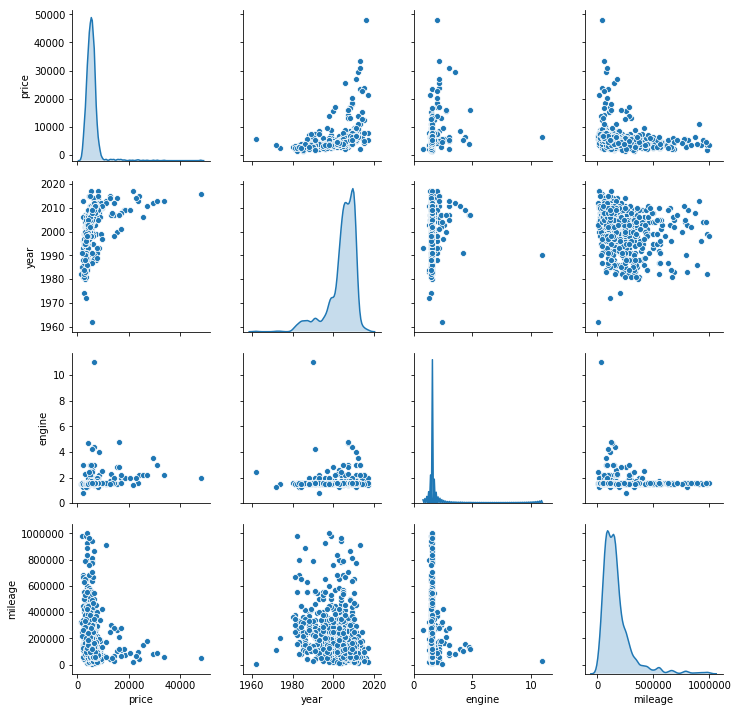

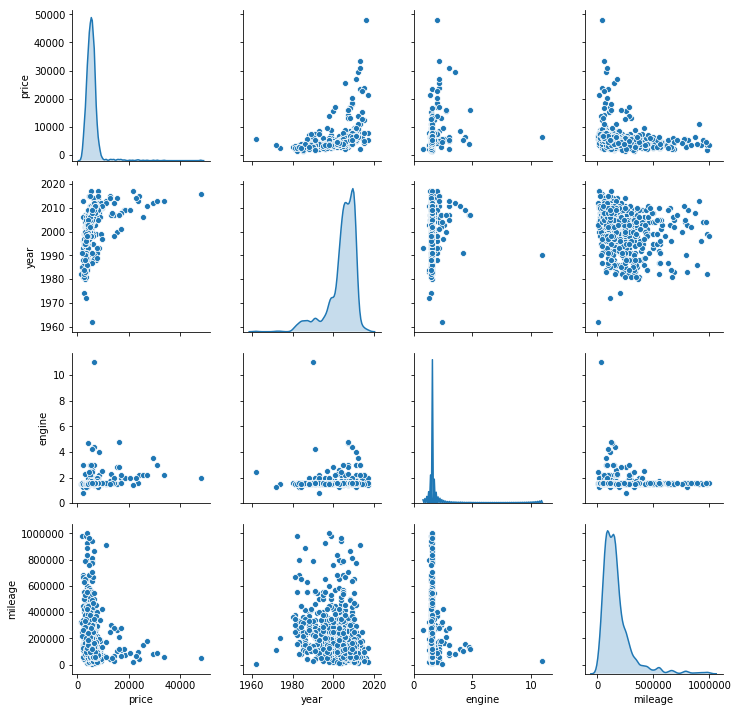

In [38]:
# Məlumatı vizualizasiya edirik
sns_plot = sns.pairplot(train_dataset[["price", "year", "engine", "mileage"]], diag_kind="kde")
sns.pairplot(train_dataset[["price", "year", "engine", "mileage"]], diag_kind="kde")
# Şəkli yaddaşa veririk.
sns_plot.savefig('output_07_LADA.png')

In [39]:
# Məşğələ məlumatlarına baxırıq
train_dataset.describe()

,price,year,engine,mileage
count,1419.000000,1419.000000,1419.000000,1419.000000
mean,5565.190275,2004.518675,1.614870,172157.385483
std,2751.839207,6.800826,0.334221,135516.250648
min,1500.000000,1962.000000,0.800000,4000.000000
25%,4300.000000,2003.000000,1.600000,90000.000000
50%,5300.000000,2006.000000,1.600000,144000.000000
75%,6325.000000,2009.000000,1.600000,200000.000000
max,47900.000000,2017.000000,11.000000,999999.000000


In [40]:
# Test məlumatlarına baxırıq.
test_dataset.describe()

,price,year,engine,mileage
count,355.000000,355.000000,355.000000,3.550000e+02
mean,5890.760563,2004.138028,1.647324,1.813474e+05
std,6632.490570,7.010532,0.569083,1.984089e+05
min,1500.000000,1982.000000,1.300000,2.000000e+03
25%,4300.000000,2003.000000,1.600000,9.000000e+04
50%,5200.000000,2006.000000,1.600000,1.452340e+05
75%,6200.000000,2009.000000,1.600000,2.000000e+05
max,110000.000000,2019.000000,11.000000,2.884486e+06


In [41]:
# qiyməti siyahıdan çıxırıq və məlumatlara baxırıq.
train_stats = train_dataset.describe()
train_stats.pop("price")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
year,1419.0,2004.518675,6.800826,1962.0,2003.0,2006.0,2009.0,2017.0
engine,1419.0,1.614870,0.334221,0.8,1.6,1.6,1.6,11.0
mileage,1419.0,172157.385483,135516.250648,4000.0,90000.0,144000.0,200000.0,999999.0


In [42]:
# Biz burada qiyməti tapacağımıza görə həm train, həm də test dataset-dən price sütununu silməliyik.
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

In [43]:
# Normallaşdırıcı funksiya
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# məşğələ və test dataseti normallaşdırırıq
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
# Aşağıdakı ikisini comment etsəniz, bu zaman real normallaşdırılmış məlumat işə düşəcəkdir.
normed_train_data = train_dataset
normed_test_data = test_dataset

In [44]:
# Model hazırlamaq üçün funksiya. Burada əlbəttə ki, layer qatlarını parametrləşdirərək, funksiya ilə təyin edə bilərik.
# Hələlik isə belə sadə qalsın.
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]))
    model.add(layers.Dense(64, activation=tf.nn.relu))
    model.add(layers.Dense(1)) 
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [45]:
# Modelimizi düzəldirik
model = build_model()

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [47]:
# normallaşdırılmış datasetdə hər hansı bir boşluq varsa, onları 0 ilə əvəzləyirik
normed_train_data.fillna(0, inplace=True)
# Məlumat belə görünür
normed_train_data[:10]

,year,engine,mileage
935,1999,1.5,199900
568,2005,1.7,125000
1685,2010,1.6,157000
1290,2009,1.6,217000
1363,2003,1.5,650237
1270,2005,1.6,45001
1147,2009,1.6,245550
575,2009,1.6,165000
784,2009,1.6,84000
1175,2011,1.6,220000


In [48]:
# test datadan 10 sətir götürüb modelimizi test edirik. Nəticədə qiymətlər çıxır. Deyə bilərik ki, model funksionaldır.
example_batch = normed_test_data[:10]
example_result = model.predict(example_batch)
print(example_result)

[[ 987.209  ]
 [1076.6665 ]
 [1610.2441 ]
 [2814.0186 ]
 [ 597.06665]
 [1272.417  ]
 [ 927.52026]
 [1065.4648 ]
 [ 927.1592 ]
 [ 146.85278]]


In [49]:
# epoch dataset üzərində məşğələlərin sayını bildirir. Yəni, 1 epoch modelin bütün məlumatları 1 dəfə "görməsi" deməkdir.
# Bizim modeldə 3750 daha yaxşı görünür, ona görə də bu rəqəmi qeyd etmişəm.
epoch = 3750

# Aşağıdakı qrafikə baxanda aydın olur ki, xəta payı müəyyən epoch sayından sonra x xəttinə paralel gedir. Bu o deməkdir ki,
# modelin öyrənməyində artıq heç bir inkişaf yoxdur. Yəni, xəta payı daha da aşağı enmir. (Qrafikə baxanda aydın olur ki. 
# xəta payı yuxarıdan başlayır və epoch sayı artıqca aşağı doğru hərəkət edir və bir nöqtədə aşağı hərəkətini saxlayır,
# y xəttinə paralel gedir. Bundan sonra modelin öyrənməsinə gərək qalmır. early_stop bu nöqtəni təyin edir və modelin 
# öyrənmə prosesini dayandırır.)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# modeli burada öyrədirik və bütün məlumatı history dəyişkənində saxlayırıq.
history = model.fit(
  normed_train_data, train_labels,
  epochs=epoch, validation_split = 0.2, verbose=0,
  callbacks=[Xetle()])

# Modeli yaddaşa vermək üçün. Sonluğu .model kimi təyin eləmişəm. Siz istədiyiniz kimi təyin edə bilərsiniz. Çox hallarda
# h5py kimi qeyd edirlər. Yaddaşa verdikdən sonra modeli daha sonra load_model() metodu ilə yükləyib istifadə edə bilərsiniz.
model.save('modelin-adi-' + str(int(time.time())) + '.model')
# early_stop modelin öyrənilməsi ərzində deqradasiya gedərsə öyrənmə prosesini avtomatik dayandırır. Bu parametri silərək modeli
# tam öyrədə bilərsiniz. Bu zaman isə overfitting əmələ gələcək. Overfitting haqqında isə daha sonra ətraflı yazacam

# Aşağıda testlər apararaq minimal uzaqlaşma xətasını tapmağa çalışmışam.
# epoch(3750) = 975.94
# epoch(4000) = 983.17
# epoch(3800) = 981.18
# epoch(3700) = 993.35
# epoch(3760) = 999.12

# Nəticədə 3750 istifadə etdim



0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 
200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 22

1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 
1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 166

2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 
2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 296

In [50]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
3745,6.403847e+06,1347.036930,6.403847e+06,7.207208e+06,1340.777886,7.207208e+06,3745
3746,6.421770e+06,1329.105166,6.421770e+06,7.172767e+06,1353.322248,7.172767e+06,3746
3747,6.094247e+06,1322.557321,6.094247e+06,7.239793e+06,1349.731056,7.239793e+06,3747
3748,6.235852e+06,1314.297473,6.235852e+06,7.188296e+06,1362.039569,7.188296e+06,3748
3749,6.044146e+06,1308.138571,6.044146e+06,7.163047e+06,1349.286164,7.163047e+06,3749


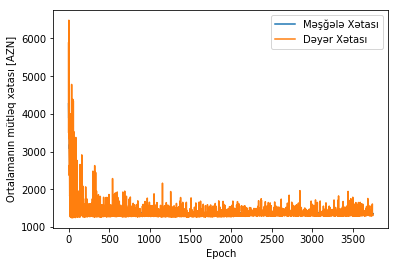

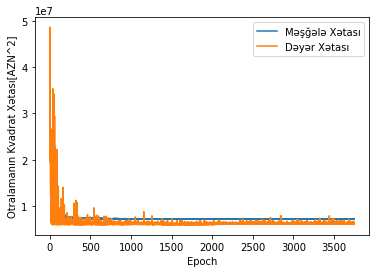

In [51]:
# Aşağıdakı qrafikdə də görünür ki, müəyyən epoch sayından sonra mütləq xəta azalmır və epoch ilə paralel gedir.
plot_history(history)

Mütləq xəta ortalaması: 1778.35 AZN


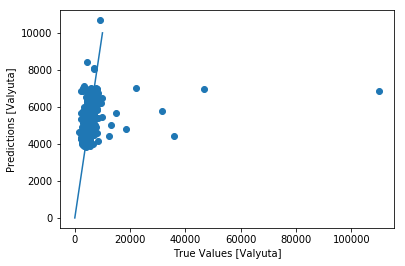

In [52]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

# Yəni, əldə etdiyimiz nəticə bu rəqəm qədər artıq və ya az ola bilər :) 
# Nə qədər aşağı olsa deməli model o qədər də yaxşı işləyir
print("Mütləq xəta ortalaması: {:5.2f} AZN".format(mae))

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Valyuta]')
plt.ylabel('Predictions [Valyuta]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _ = plt.plot([-100, 100], [-100, 100])
plt.plot([0, 10000], [0, 10000])


# Yenə də qrafikə baxanda aydın olur ki, hələ görüləcək işlərimiz çoxdur. Yəni modeli çox optimallaşdırmalıyıq.
# Xəttimiz tam olaraq da paylanmanı təmsil etmir. Bir az daha əyri xətt daha yaxşı olardı. 

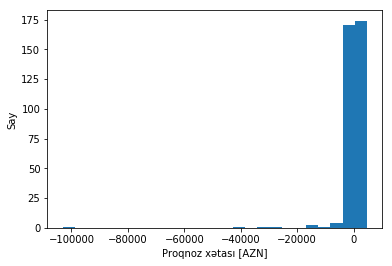

In [53]:
# Xəta/say histoqramı
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Proqnoz xətası [AZN]")
_ = plt.ylabel("Say")

In [54]:
# Burada real məlumatlardan düzəltdiyimi test məlumatlar haqqında proqnoz veririk
test_predictions = model.predict(normed_test_data[:10]).flatten()
# Proqnozu çap edirik
test_predictions

array([5566.5923, 5456.75  , 4720.0874, 4261.6753, 6114.1377, 5180.355 ,
       5650.1177, 5482.0195, 5657.4233, 6940.943 ], dtype=float32)

In [55]:
# Burada isə özümüz panda dataframe düzəldirik
new_data = pd.DataFrame({ 'year': [2010], 'engine': [1.6], 'mileage': [160000] })
# norm funksiyası ilə məlumatı normallaşdıra bilərik
normalized_new_data = new_data

In [56]:
# Məlumatı modelə ötürürük və nəticə əldə edirik
model.predict(new_data).flatten()

array([5269.0293], dtype=float32)